# Project 2 : Human Activity Recognition

### 프로젝트 제출 가이드
- 제출 기한: 2025년 2월 5일 23:59분까지
- 제출 내용: `Project2.ipynb` 파일
  - 성능이 잘 나오도록 `3.1. 하나의 샘플에 대한 특징 추출` 셀의 `extract_features` 함수 수정
  - `4.2. 5가지 분류기 구현` 셀에 5가지 분류기들을 구현
- 제출 방법: `ta_ml@hcs.snu.ac.kr`로 이메일 제출 (여러 번 제출시 마지막 버전을 사용)
- 메일 제목: `X조 ML Project 2`
- 점수 비중: 수업 전체의 30% (Project1: 10%, 시험: 60%)


### 채점 기준 [총 100점]
1. `LRClassifier`, `LDAClassifier`, `RFClassifier`, `BClassifier`, `SVMClassifier` 각 분류기당 [+20점]
  - 수행 [+15점] : `5. 테스트` 셀이 잘 수행(+10점)되어야 하고, 분류기들은 각각 아래 주어진 방식으로 분류를 수행(+5점)해야 합니다.
    - `LRClassifier` : Logistic Regression
    - `LDAClassifier` : Linear Discriminant Analysis
    - `RFClassifier` : Random Forest
    - `BClassifier` : Boosting with Decision Tree
    - `SVMClassifier` : Support Vector Machines
  - 성능 [+5점]
    - 주어지지 않은 별개의 테스트 데이터를 이용해 각 분류기의 성능을 평가합니다.
    - Test macro f1 score에 따른 점수는 아래와 같습니다. (일반적으로 Test score가 CV score보다 0.05 가량 높게 나옵니다.)
      - 0.50 미만: 0점
      - 0.55 미만: 1점
      - 0.60 미만: 2점
      - 0.65 미만: 3점
      - 0.70 미만: 4점
      - 0.70 이상: 5점
2. 띄어쓰기, 주석, Visualization 등 데이터 프로세싱과 상관없는 부분은 수정이 가능하고, 실행과 관련된 부분은 `3.1. 하나의 샘플에 대한 특징 추출` 셀과 `4.2. 5가지 분류기 구현` 셀만 수정하여야 합니다. [-50점]


### 참고 사항
1. 이전 성능이 좋았던 팀들의 경우 각 분류기들의 Cross-validation macro F1 score는 0.65 정도 나왔습니다.
2. 채점 기준에 맞는다면 `sklearn` 외의 다른 라이브러리를 사용하셔도 됩니다.

### 1. 프로젝트 개요
- 5초간 손목의 가속도계 센서 데이터를 이용해서 그 사람의 행동을 예측하는 분류기를 만듭니다.

<img src="https://gitlab.com/machine-learning-course1/ml-project-lg-2024-spring/-/raw/main/images/simple_pipeline.png" style='width:70%; margin-bottom:10px'>

<div style='text-align:center; font-weight:bold;'>그림 1. Walking, Running 예제 데이터</div>

### Import libraries

이 부분 또한 실행을 위하여 패키지를 불러와야만 한다.

In [1]:
from collections import Counter
from io import BytesIO
from multiprocessing import Pool
from pathlib import Path
import pickle
import requests
import zipfile
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import cross_val_score, LeaveOneGroupOut
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")  # 모든 경고 무시
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from joblib import parallel_backend
import scipy
from scipy.signal import find_peaks
from scipy.stats import entropy
from statsmodels.tsa.stattools import acf
from scipy.stats import skew, kurtosis

### 2. 데이터

#### 2.1. 데이터 로드

In [2]:
def load_data():
    if Path('data/train.zip').exists():
        # Read data from local file
        print('Reading data...')
        with zipfile.ZipFile('data/train.zip') as zip_file:
            with zip_file.open('train.pkl') as f:
                df = pickle.load(f)

    else:
        # Download data
        print('Downloading data...')
        DATA_URL = 'https://gitlab.com/machine-learning-course1/ml-project-lg-2025-winter/-/raw/main/data/train.zip?ref_type=heads&inline=false'
        response = requests.get(DATA_URL)
        assert response.status_code == 200

        # Read data
        print('Reading data...')
        with zipfile.ZipFile(BytesIO(response.content)) as zip_file:
            with zip_file.open('train.pkl') as f:
                df = pickle.load(f)

    # Convert to numpy arrays
    X, Y = np.stack(df['Data']), np.stack(df['Motion'])  # np.stack : pandas.Series => np.ndarray
    groups = np.stack(df['Subject'])  # For LeaveOneGroupOut

    return X, Y, groups

In [3]:
X, Y, groups = load_data()

print(f'X: {X.shape}  Y: {Y.shape}  groups: {groups.shape}')
print(f'Number of motions: {Counter(Y)}')
print(f'Number of subjects: {Counter(groups)}')

Reading data...
X: (13940, 500, 3)  Y: (13940,)  groups: (13940,)
Number of motions: Counter({'ironing': 1834, 'walking': 1814, 'standing': 1400, 'lying': 1392, 'sitting': 1366, 'Nordic walking': 1358, 'vacuum cleaning': 1290, 'cycling': 1135, 'ascending stairs': 787, 'descending stairs': 689, 'running': 659, 'rope jumping': 216})
Number of subjects: Counter({5: 2661, 8: 2558, 6: 2439, 7: 2269, 4: 2260, 3: 1694, 9: 59})


#### 2.2. 데이터 개요
- 각 샘플은 `X`, `Y`, `groups` 값으로 이루어져 있습니다.
  - `X`: (500, 3) 형태의 `numpy array` (`numpy array` 타입)
    - 5초 동안 100Hz로 3축 데이터를 모으면 (500, 3) 형태의 데이터가 됩니다.
  - `Y`: 실험자의 실제 행동 ( `str` 타입)
    - ex. `walking`, `running`, ...
  - `groups`: 실험자 ID (`int` 타입)

- `X` 정보를 가지고 `Y` 값을 유추해야합니다.
- `groups`는 Cross Validation에 활용하기 위해 제공됩니다. `HyperparameterTuning.ipynb`를 참고해주세요.

#### 2.3. 데이터 샘플 예제

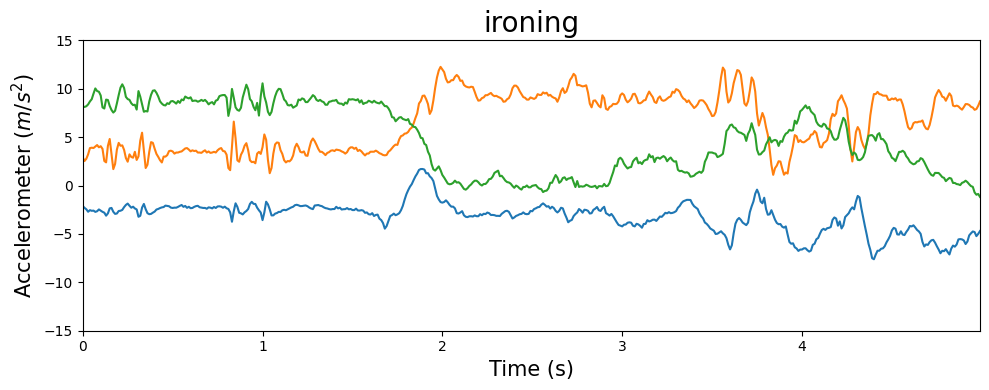

In [4]:
FPS = 100

X_sample, Y_sample = X[0], Y[0]
time_stamps = np.arange(0, len(X_sample)) / FPS


fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(time_stamps, X_sample)

ax.set_title(Y_sample, fontsize=20)
ax.set_xlabel('Time (s)', fontsize=15)
ax.set_ylabel('Accelerometer ($m/s^2$)', fontsize=15)
ax.set_xlim(min(time_stamps), max(time_stamps))
ax.set_ylim(-15, 15)

fig.tight_layout()
fig.show()

### 3. 특징 추출

In [5]:
doitnow = False # 지금 변수선택을 할 것인지 말 것인지. 이미 다 해 놨으니까 False로 합시다.
if doitnow:
    from variableselection_cjy import select_variable
    select_variable()

with open("indbwd.txt", "r") as f:
    indbwd = [int(line.strip()) for line in f]  
with open("namebwd.txt", "r") as f:
    namebwd = [(line.strip()) for line in f] 

print(f"선택된 변수는 다음과 같다.\n{namebwd}")



def extract_features(X_sample: np.ndarray) -> np.ndarray:
    
    assert X_sample.shape == (500, 3)

    #################### TODO: Extract more features ####################

    # Extract time domain features
    X_time = X_sample

    # Extract frequency domain features
    X_freq = np.abs(np.fft.fft(X_sample, axis=0))[1:]
    dominant_freq = np.argmax(X_freq)
    theta = np.angle(np.fft.fft(X_sample, axis=0))
    compx = np.exp(1j * theta)
    thetabar = np.angle(np.mean(compx, axis=0))
    jerk = np.diff(X_time, axis=0)
    jerk_count = np.sum(np.abs(jerk) > 2)
    freqs = np.fft.fftfreq(len(X_sample))
    power_spectrum = np.abs(np.fft.fft(X_sample, axis=0))**2
    low_freq_energy = np.sum(power_spectrum[freqs < freqs.mean()], axis=0)
    high_freq_energy = np.sum(power_spectrum[freqs > freqs.mean()], axis=0)
    energy_ratio = low_freq_energy / high_freq_energy
    R = np.corrcoef(X_sample.T)
    norm = np.sqrt(np.sum(X_time**2, axis=1))
    absdiffs = np.abs(np.apply_along_axis(np.diff, axis=0, arr=X_time))
    acfs = np.apply_along_axis(lambda x: acf(x.reshape(-1), nlags=5)[1:], axis=0, arr=X_sample)

    # Concatenate features
    X_features = np.hstack([
        np.mean(X_time, axis=0), # sample mean
        np.std(X_time, ddof=1, axis=0), # sample standard deviation
        np.median(X_time, axis=0), # sample median
        np.max(X_time, axis=0), # sample maximun
        np.min(X_time, axis=0), # sample minimum
        (np.abs(X_time)).sum(axis=0),
        np.sqrt((X_time**2).sum()),
        skew(X_time, axis=0),
        kurtosis(X_time, axis=0),
        np.percentile(X_time, q=0.1, axis=0),
        # np.percentile(X_time, q=0.9, axis=0),
        np.percentile(X_time, q=0.75, axis=0) - np.percentile(X_time, q=0.25, axis=0),
        dominant_freq, # dominant frequency
        np.max(X_freq, axis=0),
        entropy(X_freq),
        np.sum(X_freq ** 2, axis=0),
        thetabar, # angle mean
        np.apply_along_axis(lambda x: len(scipy.signal.find_peaks(x)[0]), axis=0, arr=X_time), # 피크 개수
        absdiffs.mean(axis=0), # 차분 절댓값 평균크기
        np.median(absdiffs, axis=0), # 차분 절댓값 중간값크기
        np.max(absdiffs, axis=0), # 차분 절댓값 최댓값
        (absdiffs.reshape(-1) > 1).sum(),
        (absdiffs.reshape(-1) > 3).sum(),
        (absdiffs.reshape(-1) > 5).sum(),
        np.argmax(absdiffs),
        np.argmin(absdiffs),
        np.percentile(absdiffs, 0.75) - np.percentile(absdiffs, 0.25),
        np.apply_along_axis(lambda x: (x[-1] - x[0])/500, axis=0, arr=X_time), # 기울기
        np.mean(np.diff(np.where(X_time > np.mean(X_time)))), # 신호 주기성
        np.mean(np.diff(np.sign(X_time), axis=0) != 0, axis=0), # zero-crossing rate
        jerk_count,
        energy_ratio,
        R[0,1], R[0,2], R[1,2],
        acfs[:,0], # X좌표의 acf lag 1~5까지
        acfs[:,1], # Y좌표의 acf lag 1~5까지
        acfs[:,2], # Z좌표의 acf lag 1~5까지
        X_freq.mean(axis=0), # freqmean
        # X_freq.std(axis=0,ddof=1), # freqstd
        np.percentile(X_freq, 0.75, axis=0) - np.percentile(X_freq, 0.25, axis=0),
        norm.mean(),
        norm.std(ddof=1),
        norm.max(),
        np.percentile(norm, 0.75) - np.percentile(norm, 0.25),

    ])
    X_features = X_features[indbwd]

    ######################################################################

    assert X_features.ndim == 1
    return X_features

선택된 변수는 다음과 같다.
['meanX', 'meanZ', 'abssumY', 'abssumZ', 'entropyX', 'sqsumfreqY', 'sqsumfreqZ', 'numpeakZ', 'absdiffmeanX', 'absdiffmeanY', 'absdiffmeanZ', 'diffbigger1', 'diffbigger3', 'corrXZ', 'acfX1', 'acfX4', 'acfX5', 'acfY3', 'normmean', 'normstd', 'normiqr']


#### 3.2. 여러 샘플에 대한 특징 추출

이거는 이런 식으로 하면 local pc vs code로 안돌아갑니다. 그래서 병렬작업을 나름대로 바꾼거니 양해바랍니다.

In [6]:
from joblib import Parallel, delayed

multi = True  # 병렬 처리 활성화

if multi:
    X_features = np.array(Parallel(n_jobs=-1)(
        delayed(extract_features)(x) for x in tqdm(X, total=len(X))
    ))
else:
    X_features = np.array([extract_features(x) for x in tqdm(X, total=len(X))])
    
print(f'X_features.shape: {X_features.shape}')

100%|██████████| 13940/13940 [00:07<00:00, 1863.37it/s]


X_features.shape: (13940, 21)


### 4. 분류

#### 4.2. 5가지 분류기 구현
- `LRClassifier`, `LDAClassifier`, `RFClassifier`, `BClassifier`, `SVMClassifier` 5가지 Classifier 구현해주세요.


##### 성능 튜닝 방법
- 어떤 특성들을 사용할지, 어떤 전처리기를 사용할지, 전처리기/분류기의 하이퍼파라미터를 어떻게 정할지 등을 바꾸어가며 성능을 높입니다.
- Cross Validation을 기반으로 테스트 결과를 예측하며 하이퍼파라미터를 설정할 수 있습니다.
  - 전처리기/분류기 튜닝 방법은 `HyperparameterTuning.ipynb`를 참고해주세요.
  - 특징 선택 방법은 `FeatureSelection.ipynb`를 참고해주세요.

In [7]:
#################### TODO: Implement your own 5 classifiers ####################
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import umap
import json
from lightgbm import LGBMClassifier

cv_rf, cv_bst, cv_svm = False, False, False # 지금 cv를 할지말지의 여부, True면 그 자리에서 CV를 시작합니다.

if cv_rf:
    from rf import do_cv
    do_cv()
else:
    with open("rf.txt", "r") as f:
        params_rf = json.load(f)
if cv_bst:
    from bst import do_cv
    do_cv()
else:
    with open("svm.txt", "r") as f:
        params_svm = json.load(f)
if cv_svm:
    from svm import do_cv
    do_cv()
else:
    with open("bst.txt", "r") as f:
        params_bst = json.load(f)

LRClassifier = Pipeline([
    ('scaler', StandardScaler()),
    ('preprocessor', PCA()), # 근데 이럴거면 PCA는 넣으나마나 아님?
    ('classifier', LogisticRegression()),
])
LDAClassifier = Pipeline([
    ('scaler', StandardScaler()),
    ('preprocessor', PCA()),
    ('classifier', LinearDiscriminantAnalysis()),
])
RFClassifier = Pipeline([
    ('scaler', StandardScaler()),
    ('preprocessor', PCA()),
    ('classifier', RandomForestClassifier(**params_rf)),
])
BClassifier = Pipeline([
    ('scaler', StandardScaler()),
    ('preprocessor', PCA()),
    ('classifier', LGBMClassifier(**params_bst)),
])
SVMClassifier = Pipeline([
    ('scaler', StandardScaler()),
    ('preprocessor', PCA()),
    ('classifier', SVC(**params_svm)),
])

################################################################################

### 5. 테스트

In [8]:
for clf in [LRClassifier, LDAClassifier, RFClassifier, BClassifier, SVMClassifier]:
    print(f"#--------------{clf}")
    scores = cross_val_score(
        clf,
        X_features, Y,
        groups=groups,          # For LeaveOneGroupOut
        cv=LeaveOneGroupOut(),  # Subject-wise cross-validation
        scoring='f1_macro',     # Scoring metric: F1 score (macro)
        verbose=0,              # (Optional) print progress or not
        n_jobs=-1,              # (Optional) use multiple cores or not
    )
    print(np.mean(scores))

#--------------Pipeline(steps=[('scaler', StandardScaler()), ('preprocessor', PCA()),
                ('classifier', LogisticRegression())])
0.7044676019875054
#--------------Pipeline(steps=[('scaler', StandardScaler()), ('preprocessor', PCA()),
                ('classifier', LinearDiscriminantAnalysis())])
0.7836734850813399
#--------------Pipeline(steps=[('scaler', StandardScaler()), ('preprocessor', PCA()),
                ('classifier',
                 RandomForestClassifier(max_depth=25, n_estimators=594))])
0.7104547025138342
#--------------Pipeline(steps=[('scaler', StandardScaler()), ('preprocessor', PCA()),
                ('classifier',
                 LGBMClassifier(learning_rate=0.05366051826221828, max_depth=5,
                                n_estimators=433, num_leaves=92))])
0.7025377729868414
#--------------Pipeline(steps=[('scaler', StandardScaler()), ('preprocessor', PCA()),
                ('classifier',
                 SVC(C=2.289250469942943, gamma=0.0405644272